In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import random
import torch
import numpy as np
import seaborn as sns

from data_analysis_preparation.utils import filter_df_by_problem
from dataloader import Mri3DDataLoader
from model import MRINet
from training_loop import evaluate_model, run_training_loop

device = torch.device("cpu")

### Reproducibility

In [2]:
torch.manual_seed(2**30) 
random.seed(2**30)
np.random.seed(2**30)

### Load data

In [3]:
TRAIN_DATA_PATH = "/Users/michaelhase/Desktop/SeniorThesis/data/tabular_data/train_base.csv"
TEST_DATA_PATH = "/Users/michaelhase/Desktop/SeniorThesis/data/tabular_data/test_base.csv"
VALID_DATA_PATH = "/Users/michaelhase/Desktop/SeniorThesis/data/tabular_data/val_base.csv"

MODEL_SAVE_DIRECTORY = "/Users/michaelhase/Desktop/SeniorThesis/models"

In [4]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)
valid_df = pd.read_csv(VALID_DATA_PATH)
num_epochs = 10

### Training and evaluation process

In [5]:
def plot_confusion_matrix(results: dict, problem: str, dataset: str) -> None:
    columns = problems[problem]
    cf_matrix = results[problem][dataset]["confusion_matrix"]
    s = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
                    fmt='.2%', cmap='Blues', xticklabels=columns,
                    yticklabels=columns)
    s.set_xlabel("Predicted label")
    s.set_ylabel("True label")

In [6]:
problems = {"AD vs CN": ["AD", "CN"] , "AD vs MCI": ["AD", "MCI"], "MCI vs CN": ["MCI", "CN"], "AD vs MCI vs CN": ["MCI", "CN", "AD"], "p-MCI vs np-MCI": ["p-MCI", "np-MCI"]}
batch_size = 4


In [7]:
histories = {}
results = {problem: {} for problem in problems}
for problem, columns in problems.items():
    print(f"Training {problem}")
    _train_df = Mri3DDataLoader(filter_df_by_problem(problem, train_df), classification_values=columns,
                                batch_size=batch_size, crop=False)
    _test_df = Mri3DDataLoader(filter_df_by_problem(problem, test_df), classification_values=columns,
                               batch_size=batch_size, crop=False)
    _valid_df = Mri3DDataLoader(filter_df_by_problem(problem, valid_df), classification_values=columns,
                                batch_size=batch_size, crop=False)

    save_directory = Path(MODEL_SAVE_DIRECTORY, problem)
    model = MRINet(num_classes=2 if problem != "AD vs MCI vs CN" else 3)
    model.to(device)  # Changed to use CPU instead of GPU
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    history = run_training_loop(model = model,
                                train_dataset=_train_df,
                                valid_dataset=_valid_df,
                                num_epochs = num_epochs,
                                optimizer = optimizer,
                                batch_size = batch_size,
                                save_directory = save_directory,
                                from_pretrained = False,
                                scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, last_epoch=-1))
    histories[problem] = history
    model.load_state_dict(torch.load(Path(save_directory, "best_model.pth")))
    results[problem] = {
        "train": evaluate_model(model, _train_df),
        "test": evaluate_model(model, _test_df),
        "valid": evaluate_model(model, _valid_df)
    }
    print(results)

Training AD vs CN


Epoch: 0, LR: [0.001] Step loss: 0.58, Step acc: 3.0, Train Accuracy: 0.553, Balanced Accuracy: 0.549, Running Loss: 1.141: 100%|██████████| 66/66 [05:22<00:00,  4.89s/it] 
Validation Loss - item: 1.063, Validation Accuracy: 0.531, Balanced accuracy: 0.531, Running Loss: 0.756: 100%|██████████| 8/8 [00:18<00:00,  2.26s/it]



Best validation accuracy: 0.53125

Saving best model for epoch: 1


Epoch: 1, LR: [0.001] Step loss: 0.55, Step acc: 3.0, Train Accuracy: 0.549, Balanced Accuracy: 0.546, Running Loss: 0.944: 100%|██████████| 66/66 [05:08<00:00,  4.68s/it] 
Validation Loss - item: 3.053, Validation Accuracy: 0.469, Balanced accuracy: 0.5, Running Loss: 2.523: 100%|██████████| 8/8 [00:19<00:00,  2.48s/it]
  0%|          | 0/66 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 2, LR: [0.001] Step loss: 0.437, Step acc: 3.0, Train Accuracy: 0.595, Balanced Accuracy: 0.59, Running Loss: 0.84: 100%|██████████| 66/66 [05:12<00:00,  4.73s/it]  
Validation Loss - item: 0.711, Validation Accuracy: 0.438, Balanced accuracy: 0.416, Running Loss: 0.813: 100%|██████████| 8/8 [00:17<00:00,  2.18s/it]
Epoch: 3, LR: [0.0001] Step loss: 0.486, Step acc: 3.0, Train Accuracy: 0.595, Balanc

{'AD vs CN': {'train': {'accuracy': 0.48863636363636365, 'balanced_accuracy': 0.527972027972028, 'roc_auc': 0.527972027972028, 'roc_curve': (array([0., 0., 1.]), array([0.        , 0.05594406, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[121,   0],
       [135,   8]])}, 'test': {'accuracy': 0.40625, 'balanced_accuracy': 0.4642857142857143, 'roc_auc': 0.4642857142857143, 'roc_curve': (array([0.        , 0.07142857, 1.        ]), array([0., 0., 1.]), array([inf,  1.,  0.])), 'confusion_matrix': array([[13,  1],
       [18,  0]])}, 'valid': {'accuracy': 0.46875, 'balanced_accuracy': 0.5277777777777778, 'roc_auc': 0.5277777777777778, 'roc_curve': (array([0., 0., 1.]), array([0.        , 0.05555556, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[14,  0],
       [17,  1]])}}, 'AD vs MCI': {}, 'MCI vs CN': {}, 'AD vs MCI vs CN': {}, 'p-MCI vs np-MCI': {}}
Training AD vs MCI


Epoch: 0, LR: [0.001] Step loss: 1.548, Step acc: 1.0, Train Accuracy: 0.618, Balanced Accuracy: 0.466, Running Loss: 0.903: 100%|██████████| 114/114 [08:09<00:00,  4.29s/it]
Validation Loss - item: 1.023, Validation Accuracy: 0.321, Balanced accuracy: 0.525, Running Loss: 0.993: 100%|██████████| 14/14 [00:30<00:00,  2.17s/it]



Best validation accuracy: 0.525

Saving best model for epoch: 1


  0%|          | 0/114 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 1, LR: [0.001] Step loss: 0.936, Step acc: 3.0, Train Accuracy: 0.678, Balanced Accuracy: 0.532, Running Loss: 0.725: 100%|██████████| 114/114 [08:14<00:00,  4.33s/it]
Validation Loss - item: 0.619, Validation Accuracy: 0.714, Balanced accuracy: 0.5, Running Loss: 0.682: 100%|██████████| 14/14 [00:31<00:00,  2.27s/it]
  0%|          | 0/114 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Epoch: 2, LR: [0.001] Step loss: 0.248, Step acc: 4.0, Train

{'AD vs CN': {'train': {'accuracy': 0.48863636363636365, 'balanced_accuracy': 0.527972027972028, 'roc_auc': 0.527972027972028, 'roc_curve': (array([0., 0., 1.]), array([0.        , 0.05594406, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[121,   0],
       [135,   8]])}, 'test': {'accuracy': 0.40625, 'balanced_accuracy': 0.4642857142857143, 'roc_auc': 0.4642857142857143, 'roc_curve': (array([0.        , 0.07142857, 1.        ]), array([0., 0., 1.]), array([inf,  1.,  0.])), 'confusion_matrix': array([[13,  1],
       [18,  0]])}, 'valid': {'accuracy': 0.46875, 'balanced_accuracy': 0.5277777777777778, 'roc_auc': 0.5277777777777778, 'roc_curve': (array([0., 0., 1.]), array([0.        , 0.05555556, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[14,  0],
       [17,  1]])}}, 'AD vs MCI': {'train': {'accuracy': 0.31140350877192985, 'balanced_accuracy': 0.5155051190329345, 'roc_auc': 0.5155051190329345, 'roc_curve': (array([0.        , 0.04958678, 1. 

Epoch: 0, LR: [0.001] Step loss: 0.626, Step acc: 2.0, Train Accuracy: 0.598, Balanced Accuracy: 0.5, Running Loss: 0.989: 100%|██████████| 120/120 [08:21<00:00,  4.18s/it]  
Validation Loss - item: 0.551, Validation Accuracy: 0.696, Balanced accuracy: 0.5, Running Loss: 0.662: 100%|██████████| 14/14 [00:31<00:00,  2.23s/it]



Best validation accuracy: 0.5

Saving best model for epoch: 1


Epoch: 1, LR: [0.001] Step loss: 0.903, Step acc: 3.0, Train Accuracy: 0.613, Balanced Accuracy: 0.495, Running Loss: 0.823: 100%|██████████| 120/120 [08:22<00:00,  4.18s/it]
Validation Loss - item: 0.19, Validation Accuracy: 0.696, Balanced accuracy: 0.5, Running Loss: 0.716: 100%|██████████| 14/14 [00:31<00:00,  2.25s/it] 
Epoch: 2, LR: [0.001] Step loss: 1.121, Step acc: 2.0, Train Accuracy: 0.675, Balanced Accuracy: 0.539, Running Loss: 0.657: 100%|██████████| 120/120 [08:25<00:00,  4.21s/it]
Validation Loss - item: 0.39, Validation Accuracy: 0.696, Balanced accuracy: 0.5, Running Loss: 0.637: 100%|██████████| 14/14 [00:31<00:00,  2.22s/it] 
  0%|          | 0/120 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
E

{'AD vs CN': {'train': {'accuracy': 0.48863636363636365, 'balanced_accuracy': 0.527972027972028, 'roc_auc': 0.527972027972028, 'roc_curve': (array([0., 0., 1.]), array([0.        , 0.05594406, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[121,   0],
       [135,   8]])}, 'test': {'accuracy': 0.40625, 'balanced_accuracy': 0.4642857142857143, 'roc_auc': 0.4642857142857143, 'roc_curve': (array([0.        , 0.07142857, 1.        ]), array([0., 0., 1.]), array([inf,  1.,  0.])), 'confusion_matrix': array([[13,  1],
       [18,  0]])}, 'valid': {'accuracy': 0.46875, 'balanced_accuracy': 0.5277777777777778, 'roc_auc': 0.5277777777777778, 'roc_curve': (array([0., 0., 1.]), array([0.        , 0.05555556, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[14,  0],
       [17,  1]])}}, 'AD vs MCI': {'train': {'accuracy': 0.31140350877192985, 'balanced_accuracy': 0.5155051190329345, 'roc_auc': 0.5155051190329345, 'roc_curve': (array([0.        , 0.04958678, 1. 

Epoch: 0, LR: [0.001] Step loss: 0.39, Step acc: 3.0, Train Accuracy: 0.428, Balanced Accuracy: 0.32, Running Loss: 1.522: 100%|██████████| 150/150 [10:27<00:00,  4.18s/it]  
Validation Loss - item: 0.887, Validation Accuracy: 0.556, Balanced accuracy: 0.333, Running Loss: 1.264: 100%|██████████| 18/18 [00:39<00:00,  2.20s/it]



Best validation accuracy: 0.3333333333333333

Saving best model for epoch: 1


  0%|          | 0/150 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 1, LR: [0.001] Step loss: 1.713, Step acc: 0.0, Train Accuracy: 0.0, Balanced Accuracy: 0.0, Running Loss: 1.713:   1%|          | 1/150 [00:04<10:44,  4.32s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 1, LR: [0.001] Step loss: 0.909, Step acc: 3.0, Train Accuracy: 0.375, Balanced Accuracy: 0.3, Running Loss: 1.311:   1%|▏         | 2/150 [00:08<10:37,  4.31s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in 


Best validation accuracy: 0.38235294117647056

Saving best model for epoch: 3


Epoch: 3, LR: [0.0001] Step loss: 0.432, Step acc: 4.0, Train Accuracy: 0.53, Balanced Accuracy: 0.359, Running Loss: 1.028: 100%|██████████| 150/150 [10:28<00:00,  4.19s/it] 
Validation Loss - item: 1.186, Validation Accuracy: 0.556, Balanced accuracy: 0.333, Running Loss: 1.096: 100%|██████████| 18/18 [00:39<00:00,  2.20s/it]
  0%|          | 0/150 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Epoch: 4, LR: [0.0001] Step loss: 0.573, Step acc: 4.0, Train Accuracy: 1.0, Balanced Accuracy: 1.0, Running Loss: 0.573:   1%|          | 1/150 [00:04<11:09,  4.49s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classe

{'AD vs CN': {'train': {'accuracy': 0.48863636363636365, 'balanced_accuracy': 0.527972027972028, 'roc_auc': 0.527972027972028, 'roc_curve': (array([0., 0., 1.]), array([0.        , 0.05594406, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[121,   0],
       [135,   8]])}, 'test': {'accuracy': 0.40625, 'balanced_accuracy': 0.4642857142857143, 'roc_auc': 0.4642857142857143, 'roc_curve': (array([0.        , 0.07142857, 1.        ]), array([0., 0., 1.]), array([inf,  1.,  0.])), 'confusion_matrix': array([[13,  1],
       [18,  0]])}, 'valid': {'accuracy': 0.46875, 'balanced_accuracy': 0.5277777777777778, 'roc_auc': 0.5277777777777778, 'roc_curve': (array([0., 0., 1.]), array([0.        , 0.05555556, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[14,  0],
       [17,  1]])}}, 'AD vs MCI': {'train': {'accuracy': 0.31140350877192985, 'balanced_accuracy': 0.5155051190329345, 'roc_auc': 0.5155051190329345, 'roc_curve': (array([0.        , 0.04958678, 1. 

  0%|          | 0/84 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 0, LR: [0.001] Step loss: 0.003, Step acc: 4.0, Train Accuracy: 0.795, Balanced Accuracy: 0.515, Running Loss: 0.681: 100%|██████████| 84/84 [05:50<00:00,  4.17s/it]
  0%|          | 0/10 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Validation Loss - item: 1.636, Validation Accuracy: 0.8, Balanced accuracy: 0.5, Running Loss: 1.108: 100%|██████████| 10/10 [00:21<00:00,  2.18s/it] 



Best validation accuracy: 0.5

Saving best model for epoch: 1


Epoch: 1, LR: [0.001] Step loss: 0.957, Step acc: 3.0, Train Accuracy: 0.804, Balanced Accuracy: 0.484, Running Loss: 0.663: 100%|██████████| 84/84 [05:50<00:00,  4.18s/it]
Validation Loss - item: 0.003, Validation Accuracy: 0.8, Balanced accuracy: 0.5, Running Loss: 1.111: 100%|██████████| 10/10 [00:21<00:00,  2.20s/it] 
Epoch: 2, LR: [0.001] Step loss: 0.388, Step acc: 3.0, Train Accuracy: 0.812, Balanced Accuracy: 0.489, Running Loss: 0.522: 100%|██████████| 84/84 [05:50<00:00,  4.18s/it]
Validation Loss - item: 0.191, Validation Accuracy: 0.8, Balanced accuracy: 0.5, Running Loss: 0.587: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it] 
  0%|          | 0/84 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
Epoch: 3

{'AD vs CN': {'train': {'accuracy': 0.48863636363636365, 'balanced_accuracy': 0.527972027972028, 'roc_auc': 0.527972027972028, 'roc_curve': (array([0., 0., 1.]), array([0.        , 0.05594406, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[121,   0],
       [135,   8]])}, 'test': {'accuracy': 0.40625, 'balanced_accuracy': 0.4642857142857143, 'roc_auc': 0.4642857142857143, 'roc_curve': (array([0.        , 0.07142857, 1.        ]), array([0., 0., 1.]), array([inf,  1.,  0.])), 'confusion_matrix': array([[13,  1],
       [18,  0]])}, 'valid': {'accuracy': 0.46875, 'balanced_accuracy': 0.5277777777777778, 'roc_auc': 0.5277777777777778, 'roc_curve': (array([0., 0., 1.]), array([0.        , 0.05555556, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[14,  0],
       [17,  1]])}}, 'AD vs MCI': {'train': {'accuracy': 0.31140350877192985, 'balanced_accuracy': 0.5155051190329345, 'roc_auc': 0.5155051190329345, 'roc_curve': (array([0.        , 0.04958678, 1. 

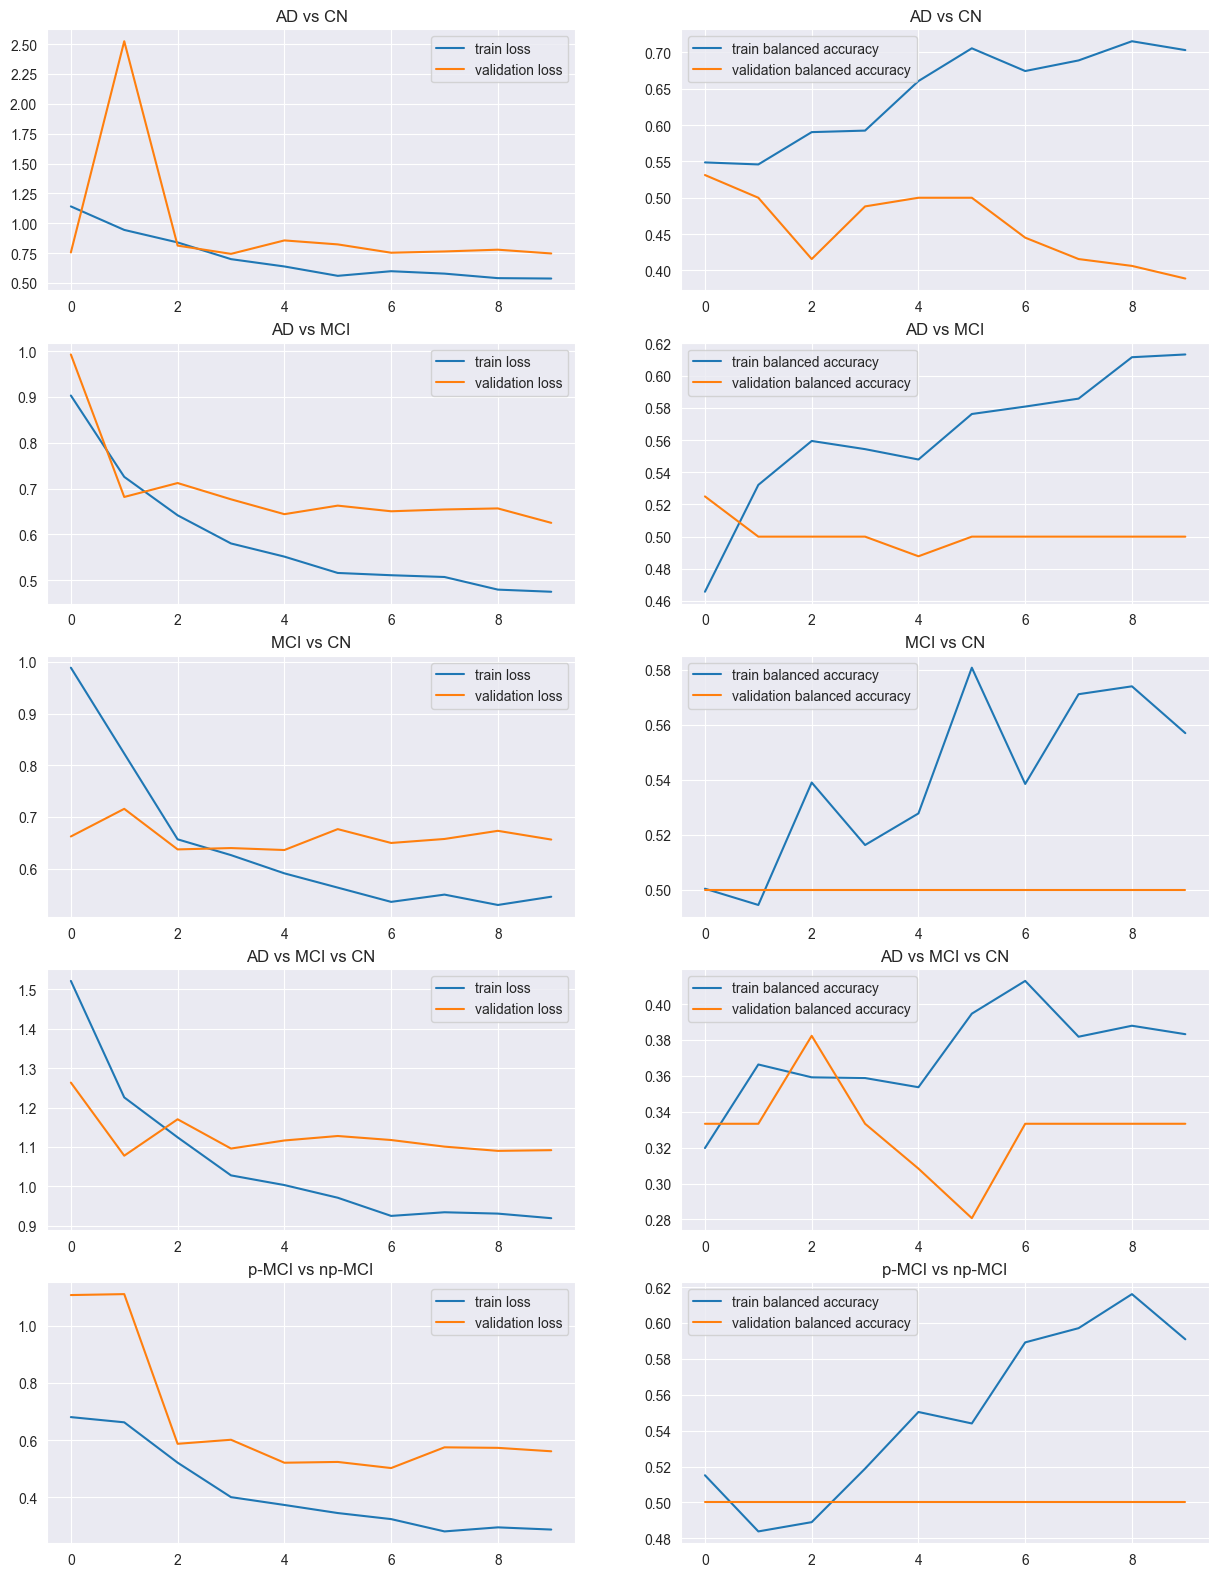

<Figure size 640x480 with 0 Axes>

In [8]:
plt.figure(figsize=(15, 40))
for i, problem in enumerate(problems):
    plt.subplot(10, 2, i*2+1)
    plt.plot(histories[problem]["train_loss"], label="train loss")
    plt.plot(histories[problem]["valid_loss"], label="validation loss")
    plt.title(problem)
    plt.legend()
    plt.subplot(10, 2, i*2+2)
    plt.plot(histories[problem]["train_balanced_accuracy"], label="train balanced accuracy")
    plt.plot(histories[problem]["valid_balanced_accuracy"], label="validation balanced accuracy")
    plt.title(problem)
    plt.legend()
plt.show()
plt.savefig(Path(MODEL_SAVE_DIRECTORY, "training_history.png"))

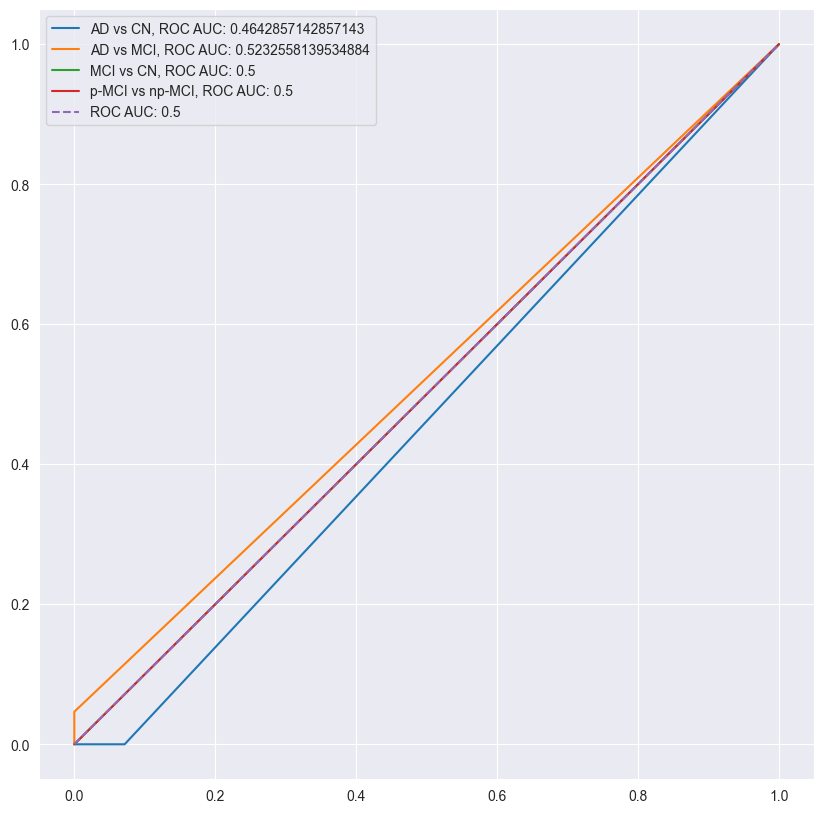

In [9]:
plt.figure(figsize=(10, 10))
for i, problem in enumerate(problems):
    if problem == "AD vs MCI vs CN":
        continue
    curve = results[problem]["test"]["roc_curve"]
    plt.plot(curve[0], curve[1], label=f"{problem}, ROC AUC: {results[problem]['test']['roc_auc']}")
plt.plot([0, 1], [0, 1], linestyle='--', label="ROC AUC: 0.5")
plt.legend()
plt.show()

In [10]:
results_dfs = {problem: pd.DataFrame(results[problem]).drop(["roc_curve", "confusion_matrix"], axis=0, errors="ignore") for problem in problems}

In [11]:
results_dfs["AD vs CN"]

,train,test,valid
accuracy,0.488636,0.40625,0.46875
balanced_accuracy,0.527972,0.464286,0.527778
roc_auc,0.527972,0.464286,0.527778


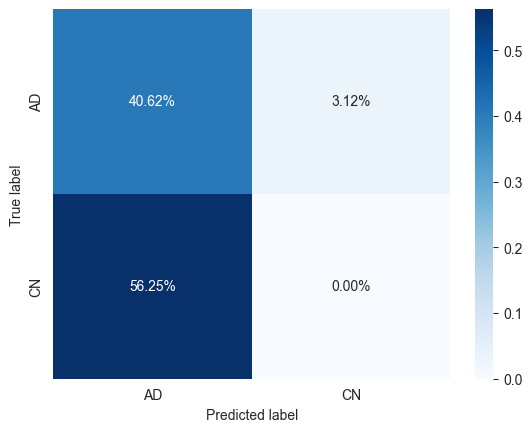

In [12]:
plot_confusion_matrix(results, "AD vs CN", "test")

In [14]:
results_dfs["AD vs MCI"]

,train,test,valid
accuracy,0.311404,0.267857,0.303571
balanced_accuracy,0.515505,0.523256,0.52439
roc_auc,0.515505,0.523256,0.52439


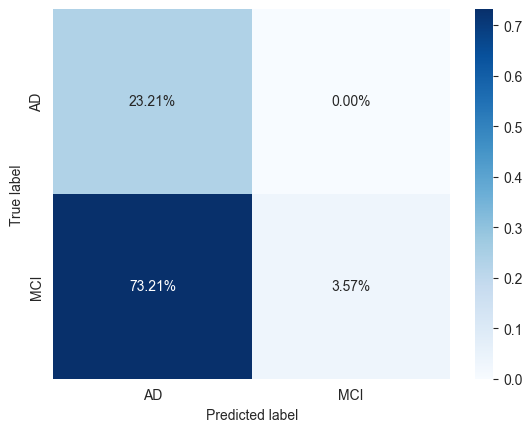

In [15]:
plot_confusion_matrix(results, "AD vs MCI", "test")

In [16]:
results_dfs["MCI vs CN"]

,train,test,valid
accuracy,0.704167,0.733333,0.678571
balanced_accuracy,0.524802,0.5,0.487179
roc_auc,0.524802,0.5,0.487179


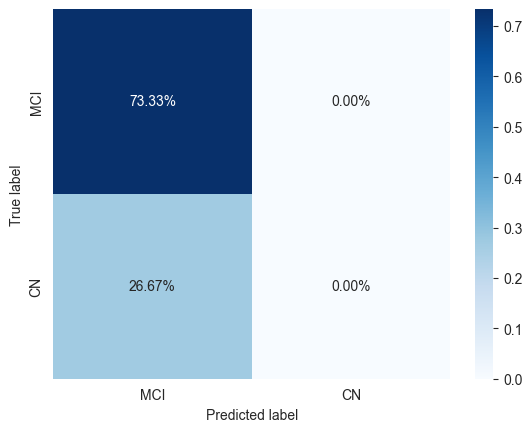

In [17]:
plot_confusion_matrix(results, "MCI vs CN", "test")

In [18]:
results_dfs["AD vs MCI vs CN"]

,train,test,valid
accuracy,0.471667,0.394737,0.430556
balanced_accuracy,0.403373,0.332026,0.382353


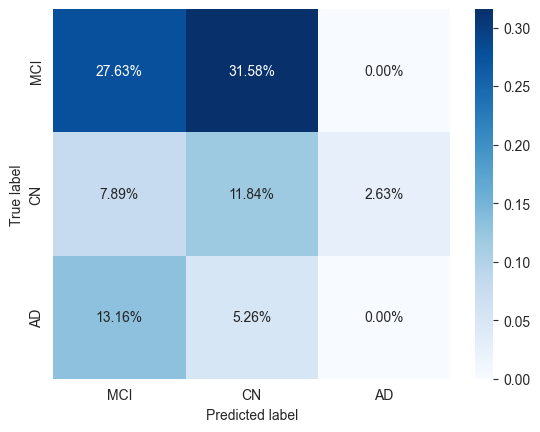

In [19]:
plot_confusion_matrix(results, "AD vs MCI vs CN", "test")

In [20]:
results_dfs["p-MCI vs np-MCI"]

,train,test,valid
accuracy,0.863095,0.909091,0.8
balanced_accuracy,0.5,0.5,0.5
roc_auc,0.5,0.5,0.5


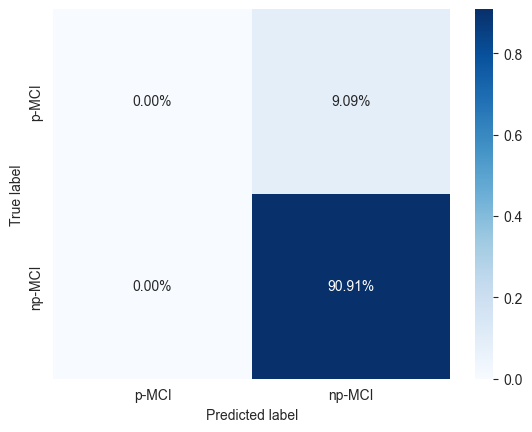

In [21]:
plot_confusion_matrix(results, "p-MCI vs np-MCI", "test")

### Augmentations

/var/folders/16/v2y5n0097wvcclskn_5f_8hm0000gn/T/ipykernel_95663/1243518706.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, i+1)


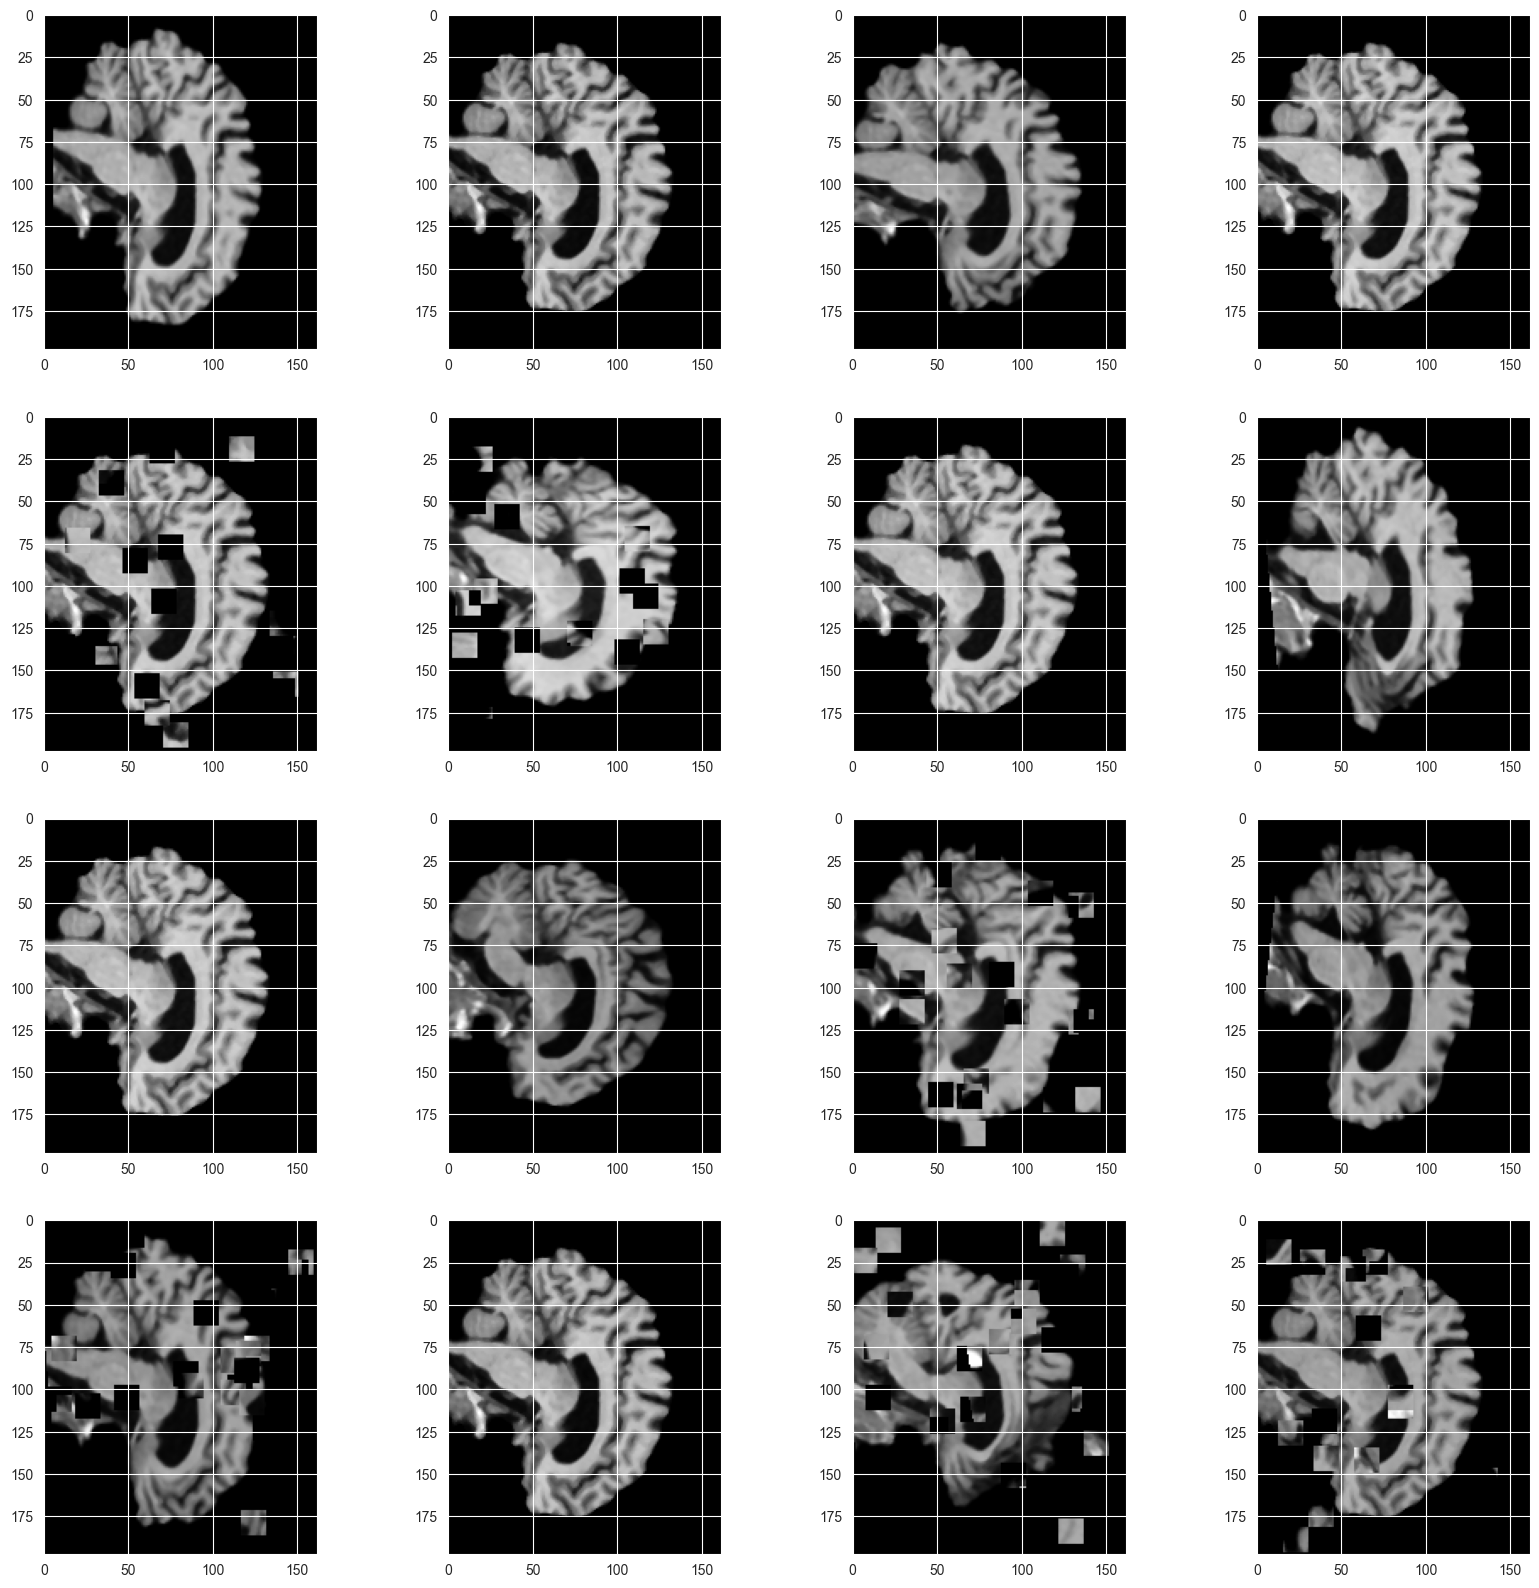

In [25]:
augment_dataloader = Mri3DDataLoader(filter_df_by_problem("AD vs CN", train_df), classification_values=["AD", "CN"], batch_size=batch_size, augment=True)

plt.figure(figsize=(20, 20))
plt.title("Augmented images")
for i in range(16):
    plt.subplot(4, 4, i+1)
    image = augment_dataloader.get_single_item(5)[0].cpu().numpy()
    plt.imshow(image[0,0,70, :, :], cmap="gray")
plt.savefig(Path(MODEL_SAVE_DIRECTORY, "augmentation_sample.png"))
plt.show()

In [ ]:
augment_histories = {}
augment_results = {problem: {} for problem in problems}

for problem, columns in problems.items():
    print(f"Training {problem}")
    
    _train_df = Mri3DDataLoader(
        filter_df_by_problem(problem, train_df), 
        classification_values=columns,
        batch_size=batch_size, 
        crop=False, 
        augment=True
    )
    
    _test_df = Mri3DDataLoader(
        filter_df_by_problem(problem, test_df), 
        classification_values=columns,
        batch_size=batch_size, 
        crop=False
    )
    
    _valid_df = Mri3DDataLoader(
        filter_df_by_problem(problem, valid_df), 
        classification_values=columns,
        batch_size=batch_size, 
        crop=False
    )
    
    save_directory = Path(MODEL_SAVE_DIRECTORY, "augmentations", problem)
    
    model = MRINet(num_classes=2 if problem != "AD vs MCI vs CN" else 3)
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    history = run_training_loop(
        model=model,
        train_dataset=_train_df,
        valid_dataset=_valid_df,
        num_epochs=num_epochs,
        optimizer=optimizer,
        batch_size=batch_size,
        save_directory=save_directory,
        from_pretrained=False,  # Not using pretrained model
        scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, last_epoch=-1)
    )
    
    augment_histories[problem] = history
    model.load_state_dict(torch.load(Path(save_directory, "best_model.pth")))
    
    augment_results[problem] = {
        "train": evaluate_model(model, _train_df),
        "test": evaluate_model(model, _test_df),
        "valid": evaluate_model(model, _valid_df),
    }
    
    print(augment_results[problem])

Training AD vs CN


Epoch: 0, LR: [0.001] Step loss: 1.247, Step acc: 2.0, Train Accuracy: 0.488, Balanced Accuracy: 0.486, Running Loss: 1.027:  64%|██████▎   | 42/66 [03:43<02:07,  5.31s/it]

In [ ]:
plt.figure(figsize=(15, 40))
for i, problem in enumerate(problems):
    plt.subplot(10, 2, i*2+1)
    plt.plot(augment_histories[problem]["train_loss"], label="train loss")
    plt.plot(augment_histories[problem]["valid_loss"], label="validation loss")
    plt.title(problem)
    plt.legend()
    plt.subplot(10, 2, i*2+2)
    plt.plot(augment_histories[problem]["train_balanced_accuracy"], label="train balanced accuracy")
    plt.plot(augment_histories[problem]["valid_balanced_accuracy"], label="validation balanced accuracy")
    plt.title(problem)
    plt.legend()
plt.show()
plt.savefig(Path(MODEL_SAVE_DIRECTORY, "training_history_augmentation.png"))

In [ ]:
results_dfs = {problem: pd.DataFrame(augment_results[problem]).drop(["roc_curve", "confusion_matrix"], axis=0, errors="ignore") for problem in problems}

In [ ]:
results_dfs["AD vs CN"]

In [ ]:
plot_confusion_matrix(augment_results, "AD vs CN", "test")

In [ ]:
plot_confusion_matrix(augment_results, "AD vs CN", "biocard")

In [ ]:
results_dfs["AD vs MCI"]

In [ ]:
plot_confusion_matrix(augment_results, "AD vs MCI", "test")

In [ ]:
plot_confusion_matrix(augment_results, "AD vs MCI", "biocard")

In [ ]:
results_dfs["MCI vs CN"]

In [ ]:
plot_confusion_matrix(augment_results, "MCI vs CN", "test")

In [ ]:
plot_confusion_matrix(augment_results, "MCI vs CN", "biocard")

In [ ]:
results_dfs["AD vs MCI vs CN"]

In [ ]:
plot_confusion_matrix(augment_results, "AD vs MCI vs CN", "test")

In [ ]:
plot_confusion_matrix(augment_results, "AD vs MCI vs CN", "biocard")

In [ ]:
results_dfs["p-MCI vs np-MCI"]

In [ ]:
plot_confusion_matrix(augment_results, "p-MCI vs np-MCI", "test")